In [286]:

from BDDData import *

In [287]:
import importlib
import sys
import csv
sys.path.append('..')
import numpy as np
import torch
import torch.utils.data as data
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import circulant
from product_graph import *
from utils import *

In [22]:
import BDDData
importlib.reload(BDDData)

<module 'BDDData' from '/Users/luca/Desktop/TUDelft/Y1/CS4350 ML For Graph Data/Project/ML4GD-WPF/BDDData.py'>

In [288]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [295]:
#Load dataframes
bdd_data = BDD_dataset("raw_data/BDDdata/")
print(f"Initial data shape: {bdd_data.historic_df.shape}")

#Add column with the timestep
bdd_data.add_timestep_id()
#Add flags for chaotic values
bdd_data.tag_chaotic(replace=True)
#Compute the mod for the nazelle and wind angles
bdd_data.angle_mod()
#Interpolate the missing values
bdd_data.interpolate_power()
#Values smaller than 0 are set to 0
bdd_data.cap_power_to_zero()
#Normalize Patv feature to [0,1]
bdd_data.normalize_power(min=0, max=1, method= "MinMaxScaler")
#Convert df to matrix form, where only Patv is included. Then split into train, validation and test
#The matrix contains the subset of the time series for ALL nodes, so an (TxN matrix)
train, val, test = bdd_data.split_df()
print(f"Train shape: {train.shape}, Val shape: {val.shape}, Test shape: {test.shape}")


Initial data shape: (4727520, 15)
Train shape: (134, 24624), Val shape: (134, 3600), Test shape: (134, 7056)


In [296]:
# set seed
np.random.seed(42)
# consider a p percentage of the data
p = 0.1
train_mask = np.random.choice(train.shape[1], int(train.shape[1] * p), replace=False)
val_mask = np.random.choice(val.shape[1], int(val.shape[1] * p), replace=False)
test_mask = np.random.choice(test.shape[1], int(test.shape[1] * p), replace=False)

train = train[:, train_mask]
val = val[:, val_mask]
test = test[:, test_mask]

print(f"Masked Train shape: {train.shape}, Masked Val shape: {val.shape}, Masked Test shape: {test.shape}")


Masked Train shape: (134, 246), Masked Val shape: (134, 36), Masked Test shape: (134, 70)


In [297]:
class CustomBDD_Dataset(data.Dataset):
    def __init__(self, dataset, observation_window=12, forecast_window=12, starting_turbine = 0,  ending_turbine=133):
        self.observation_window = observation_window
        self.forecast_window = forecast_window
        length = eval(f'len({dataset}[0])')#Retrieves length of dataset
        bdd_data.get_observation_forecasting_window(time_series_len=length, observation_steps=self.observation_window, forecast_steps=self.forecast_window)#Generates obs window
        self.window_of_interest =  bdd_data.sliding_indices[str(self.observation_window)+","+str(self.forecast_window)]#Retrieves windows
        self.starting_turbine = starting_turbine
        self.ending_turbine = ending_turbine
        self.dataset = dataset

    def __len__(self):
        return len(self.window_of_interest)

    def __getitem__(self, idx):
        window = self.window_of_interest[idx]
        if self.dataset == "train":
            features = train[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = train[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "val":
            features = val[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = val[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "test":
            features = test[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = test[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        else:
            raise NotImplementedError
        return torch.from_numpy(features).float(), torch.from_numpy(labels).float()

obs_window = 12
forecast_window = 12
batch_size = 100
num_nodes = 134

train_dataset = CustomBDD_Dataset("train",observation_window=obs_window,forecast_window=forecast_window)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataset = CustomBDD_Dataset("val",observation_window=obs_window,forecast_window=forecast_window)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size = batch_size)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Window of interest: {train_dataset.window_of_interest}")


Train dataset length: 222
Window of interest: [[0, 12, 24], [1, 13, 25], [2, 14, 26], [3, 15, 27], [4, 16, 28], [5, 17, 29], [6, 18, 30], [7, 19, 31], [8, 20, 32], [9, 21, 33], [10, 22, 34], [11, 23, 35], [12, 24, 36], [13, 25, 37], [14, 26, 38], [15, 27, 39], [16, 28, 40], [17, 29, 41], [18, 30, 42], [19, 31, 43], [20, 32, 44], [21, 33, 45], [22, 34, 46], [23, 35, 47], [24, 36, 48], [25, 37, 49], [26, 38, 50], [27, 39, 51], [28, 40, 52], [29, 41, 53], [30, 42, 54], [31, 43, 55], [32, 44, 56], [33, 45, 57], [34, 46, 58], [35, 47, 59], [36, 48, 60], [37, 49, 61], [38, 50, 62], [39, 51, 63], [40, 52, 64], [41, 53, 65], [42, 54, 66], [43, 55, 67], [44, 56, 68], [45, 57, 69], [46, 58, 70], [47, 59, 71], [48, 60, 72], [49, 61, 73], [50, 62, 74], [51, 63, 75], [52, 64, 76], [53, 65, 77], [54, 66, 78], [55, 67, 79], [56, 68, 80], [57, 69, 81], [58, 70, 82], [59, 71, 83], [60, 72, 84], [61, 73, 85], [62, 74, 86], [63, 75, 87], [64, 76, 88], [65, 77, 89], [66, 78, 90], [67, 79, 91], [68, 80, 92

In [298]:
x,y = next(iter(train_loader))
print(f"{x.shape=}\n{y.shape=}")

x.shape=torch.Size([100, 1608, 1])
y.shape=torch.Size([100, 1608, 1])


In [299]:
G = nx.read_gml('data/spatial_graph_2000.gml')
adj_mat = nx.adjacency_matrix(G)
adj_mat = nx.to_numpy_array(G)

In [300]:
def build_time_graph(window: int, directed: bool, cyclic: bool):
    """
    Circulant matrix as in https://arxiv.org/pdf/1712.00468.pdf (eq. 7)
    """
    if window <= 1:
        raise Exception("Ehm..")
    adjacency = circulant([0, 1] + [0 for _ in range(window-2)])
    if not cyclic:
        adjacency[0, window-1] = 0
    if not directed:
        adjacency += adjacency.transpose()

    return adjacency

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


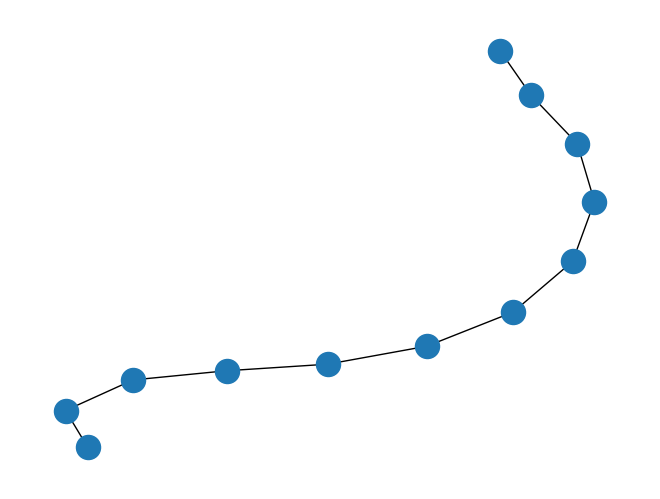

In [301]:
timegraph = build_time_graph(obs_window,True,False)
print(timegraph)
tg = nx.from_numpy_array(timegraph)
nx.draw(tg)

In [302]:
# Normalize the adjacency matrix
S = normalize_adjacency(torch.tensor(adj_mat))
S_t = torch.tensor(timegraph)

print(adj_mat.shape)

(134, 134)


In [303]:
pg = build_parametric_product_graph(S_t, S, 0, 1, 1, 1).to(device)
# pg = np.load('pg.npy')
# pg = torch.from_numpy(pg)
print(pg.shape)

torch.Size([1608, 1608])


In [304]:
##GTCNN Model with modifications to fit GNNExplainer 

import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNNLayer(nn.Module):
    def __init__(self, in_features, out_features, matrix_powers, order):
        super(GCNNLayer, self).__init__()
        self.matrix_powers = matrix_powers
        self.order = order
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features, 1))
        # use Xavier initialization to match variance of input with output
        nn.init.xavier_uniform_(self.weights)


    #Forward method for training the model with batches. 
    def batch_forward(self, features):
        batch_size = features.size(0)
        output_dim = self.weights.size(1)
        device = features.device
        out = torch.zeros((batch_size, features.size(1), output_dim), device=device)
        for k in range(self.order):
            weighted = torch.bmm(features, self.weights[:, :, k].unsqueeze(0).repeat(batch_size, 1, 1))
            shifted = torch.bmm(self.matrix_powers[k].unsqueeze(0).repeat(batch_size, 1, 1).to(device), weighted)
            out += shifted
        return out
    
    # Forward method called by training and GNNExplainer. Depending on value in kwargs={expl:value}
    # The model decides for batch processing with training or single processing to fit the inputs of the GNNExplainer. 
    def forward(self, features, edge_index=None, **kwargs):
            expl = kwargs.get('expl', None)
            if expl != True:
                #print("==========BATCH FORWARD=========") #if we do normal training
                return self.batch_forward(features) 
            else: #If the GNNExplainer calls the model
                output_dim = self.weights.size(1)
                tensor_list = []

                if features.ndim==3:
                    features = features.squeeze(0)

                out = torch.zeros((features.size(0), output_dim), device=features.device)
                for k in range(self.order):
                    weighted_features = torch.matmul(features, self.weights[:, :, k])
                    shift_k = torch.tensor(edge_index, dtype=torch.float) #uses edge_index from Explainer
                    shifted_features = torch.matmul(shift_k, weighted_features)
                    out += shifted_features
                    
                tensor_list.append(out)
                return torch.stack(tensor_list, dim=0)

# Inputs must be sized [num_nodes, obs_size] and outputs will be [num_nodes, pred_size]
class GCNN(nn.Module):
    def __init__(self, hid_sizes, shift, order=1):
        super(GCNN, self).__init__()
        self.order = order  # Set the order as an attribute of the class
        self.layers = nn.ModuleList()
        # compute matrix shift
        matrix_powers = [torch.matrix_power(shift, k).float() for k in range(order)]
        # input layer of size obs_size
        self.layers.append(GCNNLayer(1, hid_sizes[0], matrix_powers, 1))
        # num_hid hidden layers of size hid_size
        for i in range(len(hid_sizes) - 1):
            self.layers.append(GCNNLayer(hid_sizes[i], hid_sizes[i + 1], matrix_powers, 1))

    def forward(self, features, edge_index=None, index=None, **kwargs):
        expl = kwargs.get('expl', None)
        temp = features
        for layer in self.layers[:-1]:
            # use relu activation function
            temp = F.relu(layer(temp, edge_index=edge_index, **kwargs))
        if expl == True:
            temp = self.layers[-1](temp, edge_index=edge_index, **kwargs)
            return temp.squeeze(0)
        return self.layers[-1](temp, edge_index=edge_index, **kwargs)
        
model = GCNN([128,128, 1],pg,1).to(device)


In [ ]:

import time

def train_epoch(model, loader, optimizer, device='cpu'):
    model.train()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = torch.nn.functional.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_epoch(model, loader, device='cpu'):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = torch.nn.functional.mse_loss(outputs, y)
            total_loss += loss.item()
    return total_loss / len(loader)


def train_model(model, train_loader, val_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, train_loader, optimizer, device=device)
        val_loss = evaluate_epoch(model, val_loader, device=device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(f"epoch: {epoch}\ttraining loss: {train_loss:.4f}\tvalidation loss: {val_loss:.4f}")

    elapsed_time = time.time() - start_time
    if device.type == 'cuda':
        torch.cuda.synchronize()
    print(f'Model training took {elapsed_time:.3f} seconds')

    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader)

In [306]:
#Generate explanation of single node, single timestep in product graph

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=10),
    explanation_type='model',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

node_idx = 1600
kwargs = {'expl':True}

#Select a single sample(can be changed to select a different one)
for x, y in train_loader:
  x, y = x.to(device), y.to(device)
  for x_single in x:
    print(f"Single shape x: {x_single.shape}")
    explanation = explainer(x=x_single, edge_index=pg, index=node_idx, **kwargs)
    break
  break

print(explanation)

#Write explanation of single node, single timestep in product graph
tensor_data = explanation.node_mask.tolist() 
csv_file = f'explanation_data_{node_idx}.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(tensor_data)

print(f"Data saved to {csv_file}")

Single shape x: torch.Size([1608, 1])


/var/folders/f9/f489rvfn4hsdfx4c91m6h1b40000gn/T/ipykernel_17322/74766751.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  shift_k = torch.tensor(edge_index, dtype=torch.float) #uses edge_index from Explainer


Explanation(node_mask=[1608, 1], prediction=[1608, 1], target=[1608, 1], index=[1], x=[1608, 1], edge_index=[1608, 1608], expl=True)
Data saved to explanation_data_1600.csv


In [ ]:
#Run the explainer for all nodes and timesteps to obtain the importance all nodes have to eachother
#Explain whole graph and is solely used for Explainer Analysis
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    node_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

kwargs = {'expl':True}

#Select a single sample(can be changed to select a different one)
for x, y in train_loader:
  x, y = x.to(device), y.to(device)
  for x_single in x:
    x_first = x_single
    break
  break

total_explanations = []
for node_idx in range(1608): #Iterate through all nodess
    explanation = explainer(x=x_first, edge_index=pg, index=node_idx, **kwargs)
    node_explanation = explanation.node_mask.T.numpy()
    total_explanations.append(node_explanation)

combined_explanations = np.vstack(total_explanations)
print(combined_explanations.shape)

csv_file = f'total_explanation_data.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(combined_explanations)

print(f"Data saved to {csv_file}")

#Takes 1 hour

In [276]:
################################### ANALYSIS OF RESULTS ###########################

#initialization of internal/external files used for the Explainer analysis/visualization
file_path = 'total_explanation_data_EPOCH100.csv' #use the file path as generated in previous cell
data = pd.read_csv(file_path, header=None)
G = nx.read_gml('data/spatial_graph_2000.gml')
pos = {node: (data['pos'][0], data['pos'][1]) for node, data in G.nodes(data=True)}

In [277]:
# Visualization of the entire wind power network

#sum each column (axis=0) to get a single row
sum_row = data.sum(axis=0)

importance_scores_turbines = np.zeros(134)
for w in range(134):
    for t in range(12):
        product_graph_index = w + (134 * t)
        importance_scores_turbines[w] += sum_row[product_graph_index]


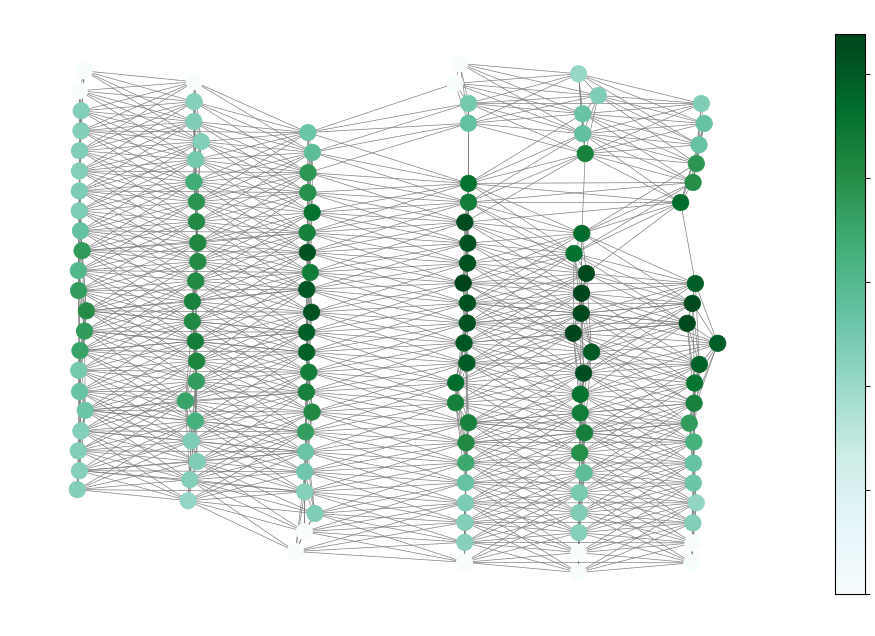

In [285]:
#Visualization for the importance explanation of the entire graph aggregated for a time window
for i, node in enumerate(G.nodes()):
    G.nodes[node]['importance'] = importance_scores_turbines[i]
importance_values = [G.nodes[node]['importance'] for node in G.nodes()]

fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.cm.BuGn  
norm = plt.Normalize(vmin=min(importance_values), vmax=max(importance_values))
colors = [cmap(norm(G.nodes[node]['importance'])) for node in G.nodes()]

#Draw the network with coordinate positions and coloring based on importance values
nx.draw(G, pos, node_size=140, node_color=colors, with_labels=False, edge_color='grey',width=0.5, linewidths=0.50, font_size=10, ax=ax)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7]) 
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')
cbar_ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

plt.savefig(f'full_network_explainer.pdf', format='pdf')
plt.show()

In [284]:
#Explanation for a single node aggregated by the time windows

#Give here the node you want to have explained!
node_idx = 1

indices = [node_idx + 134 * i for i in range(12)]
selected_rows = data.iloc[indices]
print(selected_rows.head())

sum_row = selected_rows.sum(axis=0)

importance_scores_turbines = np.zeros(134)

for w in range(134):
     for t in range(12):
         product_graph_index = w + (134 * t)
         importance_scores_turbines[w] += sum_row[product_graph_index]
         #print(f"{importance_scores_turbines[w]} \t \t { sum_row[product_graph_index]}")


         0         1         2         3         4         5         6     \
1    0.253138  0.276221  0.283396  0.252188  0.295583  0.279024  0.294662   
135  0.297483  0.277121  0.284907  0.295445  0.293952  0.333754  0.286843   
269  0.303818  0.276758  0.728777  0.699677  0.704606  0.700280  0.342771   
403  0.282048  0.731557  0.713548  0.711368  0.680143  0.711181  0.675306   
537  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         7         8         9     ...  1598  1599  1600  1601  1602  1603  \
1    0.303971  0.274618  0.264524  ...   0.0   0.0   0.0   0.0   0.0   0.0   
135  0.270740  0.271774  0.279782  ...   0.0   0.0   0.0   0.0   0.0   0.0   
269  0.285877  0.275281  0.289303  ...   0.0   0.0   0.0   0.0   0.0   0.0   
403  0.264664  0.276814  0.287921  ...   0.0   0.0   0.0   0.0   0.0   0.0   
537  0.000000  0.000000  0.000000  ...   0.0   0.0   0.0   0.0   0.0   0.0   

     1604  1605  1606  1607  
1     0.0   0.0   0.0   0.0  
135   0.

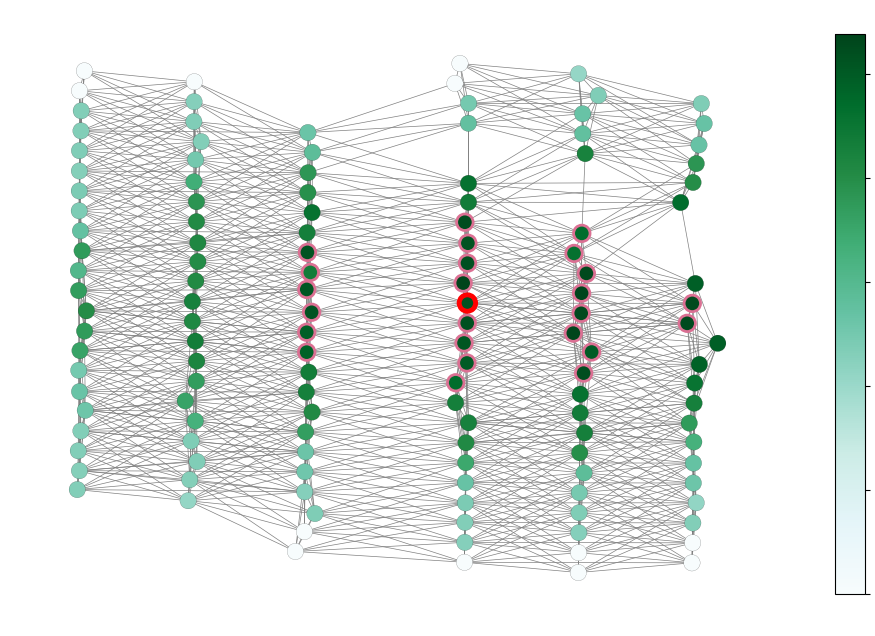

In [283]:
## Visualization for a focal node point
for i, node in enumerate(G.nodes()):
    G.nodes[node]['importance'] = importance_scores_turbines[i]

importance_values = [G.nodes[node]['importance'] for node in G.nodes()]

adj_mat = nx.adjacency_matrix(G)
adj_mat_dense = adj_mat.todense()
adjacent_indices = np.where(adj_mat_dense[[node_idx], :] > 0)[1]

#Colouring of nodes based on label
node_border_colors = ['black' for _ in G.nodes()]
node_border_widths = [0.1 for _ in G.nodes()]

#Direct neighbours
for adj_idx in adjacent_indices:
    node_border_colors[adj_idx] = 'palevioletred'
    node_border_widths[adj_idx] = 2

#Focal node
node_border_colors[node_idx] = 'red'
node_border_widths[node_idx] = 3.5


fig, ax = plt.subplots(figsize=(10, 8))

cmap = plt.cm.BuGn 
norm = plt.Normalize(vmin=min(importance_values), vmax=max(importance_values))
colors = [cmap(norm(G.nodes[node]['importance'])) for node in G.nodes()]

#draw graph based on gradient of node importance and highlighting of the focal node and highlighting of the direct neigbour nodes
nx.draw(G, pos, node_size=140, node_color=colors, with_labels=False,edgecolors=node_border_colors, edge_color='grey',width=0.5, linewidths=node_border_widths, font_size=10, ax=ax)

cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, orientation='vertical')
cbar_ax.yaxis.set_major_formatter(mpl.ticker.NullFormatter())

plt.savefig(f'network_explainer_node_{node_idx}.pdf', format='pdf')
plt.show()